In [ ]:
!pip install pandas
!pip install pandas-profiling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing

In [ ]:
# Especifica la ubicación del archivo CSV
archivo_csv = 'Casos_de_Dengue_en_Casanare_por_servicio_hospitalario__relaci_n_tipo_de_persona__s_ntomas_y_estado_hospitalario.csv'

# Utiliza la función read_csv de pandas para cargar el archivo CSV en un DataFrame
df = pd.read_csv(archivo_csv)
# Ahora, el contenido del archivo CSV se encuentra en el DataFrame 'df'

In [ ]:
# Convierte la columna 'fec_con_' a un formato de fecha y hora
df['fec_con_'] = pd.to_datetime(df['fec_con_'])
df['ini_sin_'] = pd.to_datetime(df['ini_sin_'])

# Ahora puedes usar el atributo .dt para obtener el número del mes
df['NumeroDeMes'] = df['fec_con_'].dt.month

In [ ]:
# Calcula la diferencia entre las fechas y almacénala en una nueva columna 'dias_sint'
df['dias_sint'] = (df['fec_con_'] - df['ini_sin_']).dt.days

# Muestra el DataFrame resultante
print(df['dias_sint'].describe())


count    2010.000000
mean        4.100498
std         8.704933
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max       367.000000
Name: dias_sint, dtype: float64


In [ ]:
#eliminar los registros con valores atipicos en dias_sint

# 1. Identificar los valores atípicos (por ejemplo, usando un criterio de desviación estándar)
desviacion_estandar = df['dias_sint'].std()
media = df['dias_sint'].mean()
umbral = 2  # Puedes ajustar este umbral según tus necesidades

valores_atipicos = (df['dias_sint'] - media).abs() > (umbral * desviacion_estandar)

# 2. Filtrar el DataFrame para excluir los registros con valores atípicos
df = df[~valores_atipicos]

In [ ]:
print(df['dias_sint'].describe())

count    1996.000000
mean        3.727956
std         2.037159
min         0.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        21.000000
Name: dias_sint, dtype: float64


In [ ]:
#Vamos a dejar solo las dos clases mas relevantes
df = df[df['clasfinal'] != 'No aplica']

df['clasfinal'].unique()

array(['Dengue con signomas de alarma', 'Dengue sin signomas de alarma'],
      dtype=object)

In [ ]:

#Eliminar columnas numericas con baja varianza

# Calcula la varianza de cada columna
varianza = df.var()

# Define un umbral para la varianza baja (por ejemplo, 0.01)
umbral_varianza = 0.01

# Encuentra las columnas con varianza baja
columnas_varianza_baja = varianza[varianza < umbral_varianza].index.tolist()

# Elimina las columnas con varianza baja y muestra sus nombres
df = df.drop(columns=columnas_varianza_baja)
print("Columnas eliminadas:", columnas_varianza_baja)


Columnas eliminadas: ['cod_pre']


<ipython-input-10-d783ab737ae5>:4: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  varianza = df.var()


In [ ]:
# Encuentra las columnas constantes
columnas_constantes = [col for col in df.columns if df[col].nunique() == 1]

# Elimina las columnas constantes y muestra sus nombres
df = df.drop(columns=columnas_constantes)
print("Columnas eliminadas:", columnas_constantes)

Columnas eliminadas: ['ndep_resi', 'fiebre', 'gp_carcela', 'gp_indigen', 'gp_desmovi', 'gp_psiquia', 'gp_vic_vio', 'nom_eve']


Se propone evaluar si una variable no es informativa si tiene demasiadas filas que tienen el mismo valor. Si más del 95% de filas tienen el mismo valor, se considera que la variable no aporta valor.

In [ ]:
# Calcula la cantidad total de filas en el DataFrame
num_rows = len(df.index)

# Lista para almacenar las columnas con baja información
low_information_cols = []

# Itera a través de todas las columnas del DataFrame
for col in df.columns:
    # Calcula la frecuencia de cada valor en la columna
    cnts = df[col].value_counts(dropna=False)

    # Calcula el porcentaje del valor más frecuente
    top_pct = (cnts / num_rows).iloc[0]

    # Si el porcentaje del valor más frecuente es mayor al 95%
    if top_pct > 0.95:
        # Agrega la columna a la lista de baja información
        low_information_cols.append(col)

        # Muestra el nombre de la columna, el porcentaje y la frecuencia de valores
        print(f'{col}: {top_pct*100:.5f}%')
        print(cnts)
        print()

# Elimina las columnas de baja información del DataFrame
df.drop(columns=low_information_cols, inplace=True)

In [ ]:
# Eliminar columnas por reglas de negocio
columnas_a_eliminar = ["ini_sin_","fec_not", "fec_con_", "fecha_nto_", "fec_aju_", "orden","año","cod_sub", "fec_arc_xl","nom_upgd"]
df.drop(columns=columnas_a_eliminar, inplace=True)


In [ ]:
# Encuentra las columnas con valores nulos
df.isnull().sum()



semana           0
edad_            0
sexo_            0
Ciclo_de_vida    0
cefalea          0
dolrretroo       0
malgias          0
artralgia        0
erupcionr        0
dolor_abdo       0
vomito           0
diarrea          0
pac_hos_         0
caida_plaq       0
clasfinal        0
conducta         0
NumeroDeMes      0
dias_sint        0
dtype: int64

Se proponer realizar un Label Encoding para las variables categoricas.Este metodo consiste en convertir los valores de texto en un formato numérico, para asi sea un formato más legible para la máquina. Los algoritmos de machine learning pueden discretizar de una mejor manera cuando estan en formato númerico.

In [ ]:
df["clasfinal"].unique()

array(['Dengue con signomas de alarma', 'Dengue sin signomas de alarma'],
      dtype=object)

In [ ]:
le = preprocessing.LabelEncoder()
#actualizamos las variables categoricas para incluir las nuevas.
var_categoricas =  df.select_dtypes(include=['object']).columns


for variable in var_categoricas:
  df[variable] = le.fit_transform(df[variable])

Para la eliminación de variables se propone la técnica "Backward Elimination" o eliminación hacia atrás, en español, es un enfoque utilizado en el análisis de regresión para seleccionar las variables más relevantes para un modelo de forma iterativa. El objetivo de esta técnica es eliminar de manera gradual las variables irrelevantes o menos significativas para mejorar el rendimiento del modelo.

In [ ]:
import statsmodels.api as sm
import pandas as pd
# Dividir los datos en variables predictoras (X) y variable objetivo (y)
X = df[df.columns[df.columns != 'clasfinal']] # Seleccionar todas las columnas excepto la última
y = df.clasfinal  # Seleccionar la última columna

# Agregar una columna de unos para representar el término constante en el modelo
X = sm.add_constant(X)

# Ajustar el modelo de regresión inicial
model = sm.OLS(y, X)
results = model.fit()

# Crear una lista para almacenar los nombres de las variables eliminadas
variables_eliminadas = []

# Realizar la eliminación hacia atrás iterativa
while len(X.columns) > 1:
    # Obtener el valor p más alto en el modelo actual
    max_p_value = results.pvalues[1:]
    max_p_index = max_p_value.idxmax()

    # Si el valor p máximo es mayor que un umbral predefinido, eliminar la variable correspondiente
    if max_p_value[max_p_index] > 0.5:
        variables_eliminadas.append(max_p_index)
        X = X.drop(max_p_index, axis=1)

        # Volver a ajustar el modelo sin la variable eliminada
        model = sm.OLS(y, X)
        results = model.fit()
    else:
        break

# Obtener los resultados finales
print(results.summary())

# Imprimir los nombres de las variables eliminadas
print("Variables eliminadas:", variables_eliminadas)

                            OLS Regression Results                            
Dep. Variable:              clasfinal   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     49.31
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          1.92e-103
Time:                        02:27:14   Log-Likelihood:                -1186.3
No. Observations:                1994   AIC:                             2399.
Df Residuals:                    1981   BIC:                             2471.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8095      0.048     17.042

In [ ]:
# Eliminar columnas por reglas de negocio
columnas_a_eliminar = ['cefalea', 'edad_', 'NumeroDeMes', 'diarrea', 'erupcionr', 'caida_plaq']
df.drop(columns=columnas_a_eliminar, inplace=True)


Para la selección de datos se propone usar la metrica: Correlación.

La correlación es una medida estadística que expresa la fuerza de la relación entre dos variables. Los dos tipos principales de correlación son positivos y negativos. La correlación positiva ocurre cuando dos variables se mueven en la misma dirección; a medida que uno aumenta, también lo hace el otro. La negativa, cuando dos variables se mueven en direcciones opuestas; a medida que uno aumenta, el otro disminuye.

<Axes: >

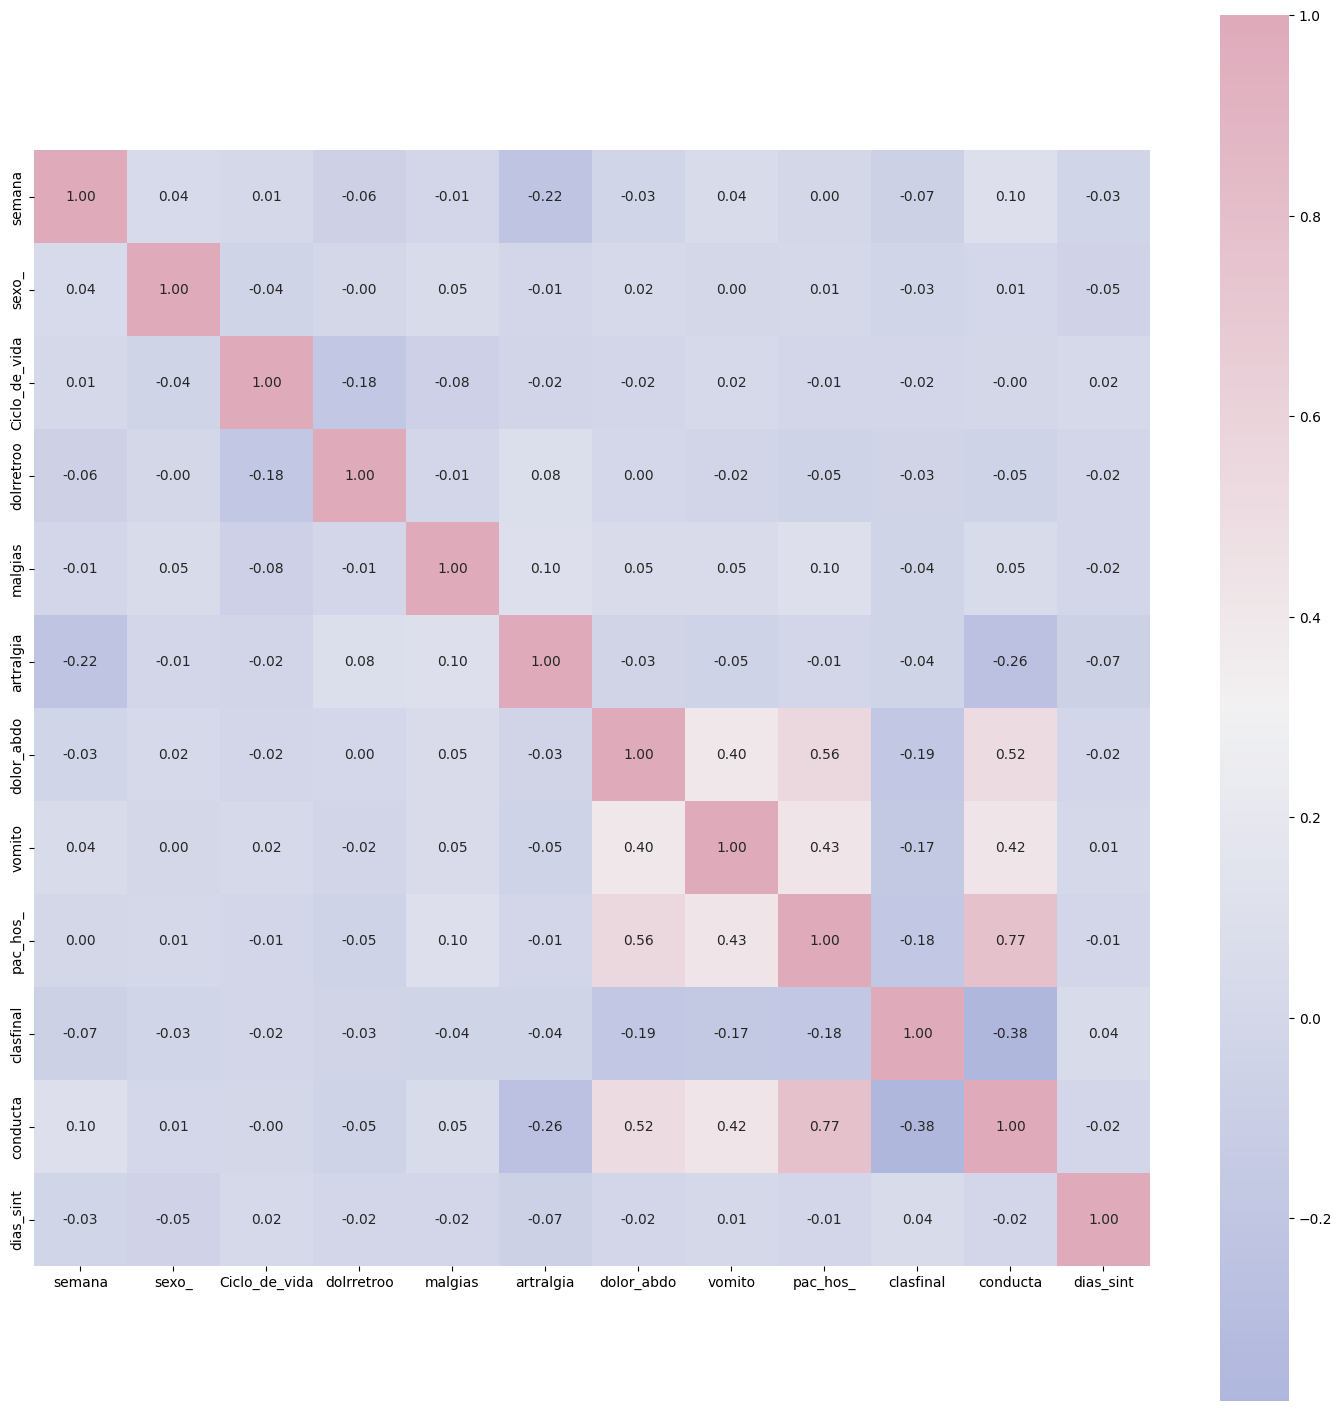

In [ ]:
corrmat = df.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat, fmt='.2f', cmap= cmap,annot=True, square=True)

En ningun caso se supera el limite de 95% de correlación entre variables

En este punto se da por finalizado el Procesamiento y se grantixa la calidad de los Datos.

In [ ]:
# Contar el número de filas y columnas
num_filas, num_columnas = df.shape

# Mostrar el número de filas y columnas
print("Número de filas:", num_filas)
print("Número de columnas:", num_columnas)
# Supongamos que tienes un DataFrame llamado df
column_names = df.columns.tolist()

# Imprime la lista de nombres de columnas
print(column_names)

Número de filas: 1994
Número de columnas: 12
['semana', 'sexo_', 'Ciclo_de_vida', 'dolrretroo', 'malgias', 'artralgia', 'dolor_abdo', 'vomito', 'pac_hos_', 'clasfinal', 'conducta', 'dias_sint']


In [ ]:
# Guardar cambios en archivo CSV
df.to_csv('dengue_procesado.csv', index=False)

##Modelado + Evaluación + Despliegue

Lectura del dataset generado en la fase de "Preparación de los datos"

In [ ]:
datos = pd.read_csv('dengue_procesado.csv', sep=',')
print(datos.columns)
datos.describe()

Index(['semana', 'sexo_', 'Ciclo_de_vida', 'dolrretroo', 'malgias',
       'artralgia', 'dolor_abdo', 'vomito', 'pac_hos_', 'clasfinal',
       'conducta', 'dias_sint'],
      dtype='object')


,semana,sexo_,Ciclo_de_vida,dolrretroo,malgias,artralgia,dolor_abdo,vomito,pac_hos_,clasfinal,conducta,dias_sint
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,21.556670,0.480441,2.225176,0.465898,0.883149,0.294885,0.266299,0.190572,0.476429,0.491474,0.842528,3.721665
std,12.051114,0.499743,1.653941,0.498961,0.321323,0.456105,0.442133,0.392851,0.499569,0.500053,0.962559,2.019539
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,19.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,28.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,4.000000
max,53.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,21.000000


In [ ]:

# Labels (etiquetas)
labels = datos['clasfinal']

# Features (características)
features = datos[['semana', 'sexo_', 'Ciclo_de_vida', 'dolrretroo', 'malgias',
               'artralgia', 'dolor_abdo', 'vomito', 'pac_hos_', 'conducta', 'dias_sint']]


In [ ]:
print(f"Vista de los datos del atributo target: \n{labels[:10]}")
print("-"*50)
print("Vista parcial de los datos sin el atributo target:")
features.head()

Vista de los datos del atributo target: 
0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
8    0
9    1
Name: clasfinal, dtype: int64
--------------------------------------------------
Vista parcial de los datos sin el atributo target:


,semana,sexo_,Ciclo_de_vida,dolrretroo,malgias,artralgia,dolor_abdo,vomito,pac_hos_,conducta,dias_sint
0,40,0,2,0,1,0,0,0,0,0,6
1,41,0,2,0,1,1,0,0,0,0,2
2,40,1,4,0,1,0,0,0,0,0,5
3,33,0,3,0,1,1,0,0,0,0,5
4,41,0,2,0,0,1,1,0,1,1,0


Generación de los datasets de entrenamiento y testing

In [ ]:
from sklearn.model_selection import train_test_split

# Se reparten los datos disponibles en conjuntos para entrenamiento y testeo

train_data, test_data, train_labels, test_labels = train_test_split(features, labels)

# Toma por defecto 75% (entrenamiento) - 25% (testeo)
# Se podría modificar con el parámetro test_size = 0.## y el complemento para training


In [ ]:
# Vista de los datos de entrenamiento para una fila

print(f"Un registro de entrenamiento: \n{train_data.iloc[0]}")
print("-"*50)
print(f"Label del registro: \n{train_labels[0]}")

Un registro de entrenamiento: 
semana           1
sexo_            0
Ciclo_de_vida    4
dolrretroo       0
malgias          1
artralgia        0
dolor_abdo       0
vomito           0
pac_hos_         0
conducta         0
dias_sint        3
Name: 1436, dtype: int64
--------------------------------------------------
Label del registro: 
0


In [ ]:
#Importaciones varias para la evaluación

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Configuración de la evaluación

def evaluar_modelo(modelo, test_data, test_labels):
    prediction = modelo.predict(test_data)
    print('Rendimiento obtenido:',accuracy_score(test_labels,prediction))
    print('Reporte de indicadores:\n',classification_report(test_labels,prediction))
    print('Matriz de confusión:')
    cm = confusion_matrix(test_labels, prediction, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=clf.classes_)
    disp.plot()
    plt.show()


ZeroR

In [ ]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier()
clf.fit(train_data, train_labels)

prediction = clf.predict(test_data)
print('Rendimiento obtenido:',accuracy_score(test_labels, prediction))
print('Vista de una muestra de valores de predicción y datos de testeo:')
print(prediction[:10])
print(test_labels[:10])


Rendimiento obtenido: 0.49899799599198397
Vista de una muestra de valores de predicción y datos de testeo:
[0 0 0 0 0 0 0 0 0 0]
1552    0
786     1
511     0
1284    1
90      0
279     1
1619    1
1820    1
1047    0
1380    1
Name: clasfinal, dtype: int64


In [ ]:
# Para obtener todos los parámetros y no solo los modificados

from sklearn import set_config

set_config(print_changed_only=False)

Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

# Prueba Nro.1
#lreg = LogisticRegression(solver = 'liblinear')
# Prueba Nro2
lreg = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)


lreg.fit(train_data, train_labels)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Rendimiento obtenido: 0.9038076152304609
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       249
           1       0.90      0.90      0.90       250

    accuracy                           0.90       499
   macro avg       0.90      0.90      0.90       499
weighted avg       0.90      0.90      0.90       499

Matriz de confusión:


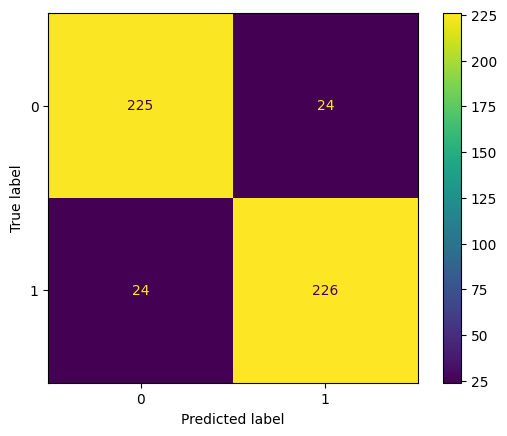

In [ ]:
#Prueba Nro. 1
evaluar_modelo(lreg, test_data, test_labels)


#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Prueba nro. 1
#knn = KNeighborsClassifier(n_neighbors=50, algorithm = 'ball_tree', leaf_size = 25)
#Prueba 2
# Ajustar los parámetros del clasificador
knn = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', leaf_size=30)

knn.fit(train_data, train_labels)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Rendimiento obtenido: 0.7414829659318637
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.71      0.80      0.76       249
           1       0.78      0.68      0.72       250

    accuracy                           0.74       499
   macro avg       0.75      0.74      0.74       499
weighted avg       0.75      0.74      0.74       499

Matriz de confusión:


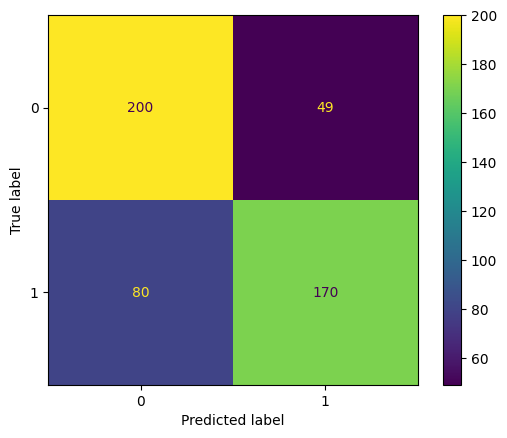

In [ ]:
#Prueba Nro. 1
evaluar_modelo(knn, test_data, test_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Preprocesar los datos (opcional)
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Ajustar los parámetros del clasificador
knn = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', leaf_size=30)

# Realizar validación cruzada
scores = cross_val_score(knn, train_data_scaled, train_labels, cv=5)

# Entrenar el clasificador
knn.fit(train_data_scaled, train_labels)

# Evaluar el rendimiento
mean_accuracy = scores.mean()
print("Precisión promedio en validación cruzada:", mean_accuracy)

# Utilizar el clasificador entrenado para hacer predicciones en nuevos datos
test_data_scaled = scaler.transform(test_data)
predictions = knn.predict(test_data_scaled)

Precisión promedio en validación cruzada: 0.8869565217391304


Rendimiento obtenido: 0.7414829659318637
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.71      0.80      0.76       249
           1       0.78      0.68      0.72       250

    accuracy                           0.74       499
   macro avg       0.75      0.74      0.74       499
weighted avg       0.75      0.74      0.74       499

Matriz de confusión:


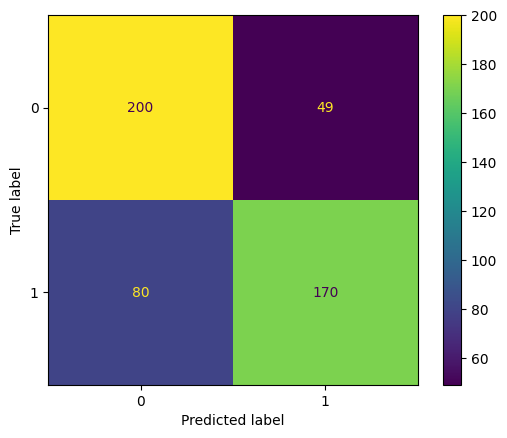

In [ ]:
# Prueba nro. 1
evaluar_modelo(knn, test_data, test_labels)

#Árboles (TDIDT)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Preprocesar los datos (opcional)
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Ajustar los parámetros del clasificador
knn = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', leaf_size=30)

# Realizar validación cruzada
scores = cross_val_score(knn, train_data_scaled, train_labels, cv=5)

# Entrenar el clasificador
knn.fit(train_data_scaled, train_labels)

# Evaluar el rendimiento
mean_accuracy = scores.mean()
print("Precisión promedio en validación cruzada:", mean_accuracy)

# Utilizar el clasificador entrenado para hacer predicciones en nuevos datos
test_data_scaled = scaler.transform(test_data)
predictions = knn.predict(test_data_scaled)


Precisión promedio en validación cruzada: 0.8869565217391304


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Prueba Nro. 1
dtc = DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_split=10)

dtc.fit(train_data, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

Rendimiento obtenido: 0.9318637274549099
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       249
           1       0.91      0.96      0.93       250

    accuracy                           0.93       499
   macro avg       0.93      0.93      0.93       499
weighted avg       0.93      0.93      0.93       499

Matriz de confusión:


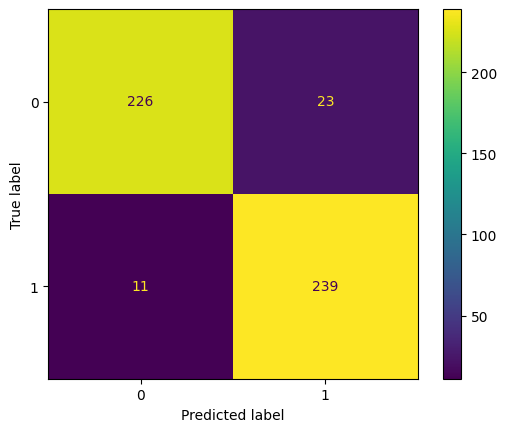

In [ ]:
# Prueba Nro. 1
evaluar_modelo(dtc, test_data, test_labels)

#Métodos de ensamblado de modelos: RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Prueba nro. 1
rndf = RandomForestClassifier(n_estimators=10)
rndf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Rendimiento obtenido: 0.8997995991983968
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       249
           1       0.90      0.90      0.90       250

    accuracy                           0.90       499
   macro avg       0.90      0.90      0.90       499
weighted avg       0.90      0.90      0.90       499

Matriz de confusión:


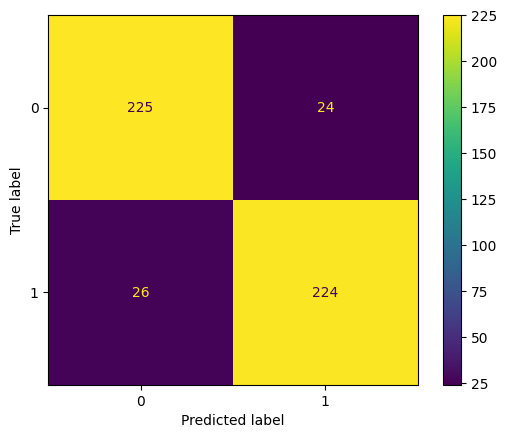

In [ ]:
# Prueba nro. 1
evaluar_modelo(rndf, test_data, test_labels)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Prueba nro. 1
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

gbc.fit(train_data, train_labels)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='log_loss', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Rendimiento obtenido: 0.9258517034068137
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       249
           1       0.92      0.94      0.93       250

    accuracy                           0.93       499
   macro avg       0.93      0.93      0.93       499
weighted avg       0.93      0.93      0.93       499

Matriz de confusión:


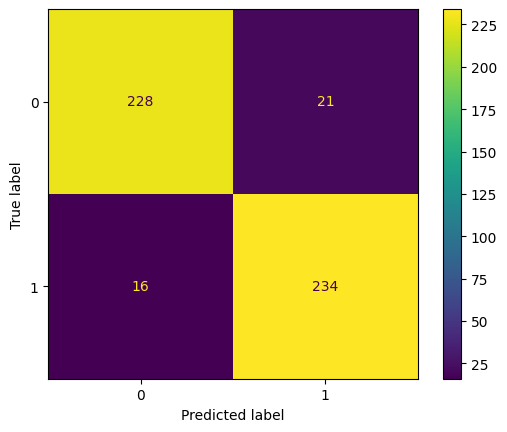

In [ ]:
# Prueba nro. 1
evaluar_modelo(gbc, test_data, test_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar el modelo RandomForestClassifier con los datos de entrenamiento
rndf = RandomForestClassifier(n_estimators=100,  # Aumenta el número de árboles
                              max_depth=None,  # Utiliza la profundidad máxima predeterminada
                              min_samples_split=2,  # Número mínimo de muestras para dividir un nodo
                              min_samples_leaf=1,  # Número mínimo de muestras en una hoja
                              random_state=42)  # Fija la semilla aleatoria para reproducibilidad
rndf.fit(test_data, test_labels)  # Asumiendo que test_data y test_labels son tus datos de prueba


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Rendimiento obtenido: 1.0
Reporte de indicadores:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       250

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499

Matriz de confusión:


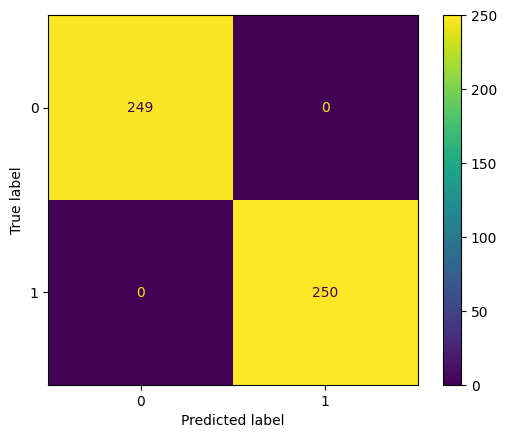

In [ ]:
# Prueba nro. 3
evaluar_modelo(rndf, test_data, test_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar el modelo RandomForestClassifier
rndf = RandomForestClassifier(n_estimators=10)
rndf.fit(test_data, test_labels)  # Asumiendo que X_train e y_train son tus datos de entrenamiento


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Rendimiento obtenido: 0.9899799599198397
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       249
           1       0.99      0.99      0.99       250

    accuracy                           0.99       499
   macro avg       0.99      0.99      0.99       499
weighted avg       0.99      0.99      0.99       499

Matriz de confusión:


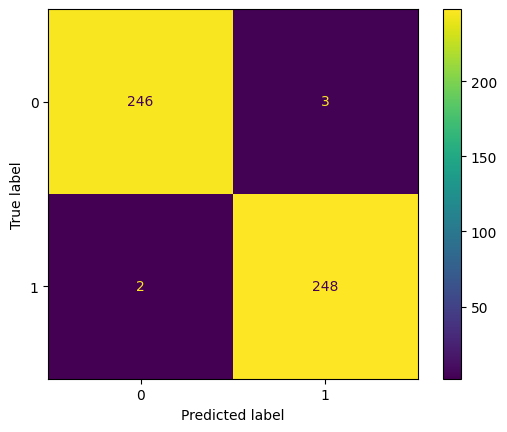

In [ ]:
# Prueba nro. 1
evaluar_modelo(rndf, test_data, test_labels)  # Asumiendo que X_test e y_test son tus datos de prueba
